# Lab 3.4: Multi-class Classification Setup

## Learning Objectives
- Implement multi-class classification using softmax activation
- Understand categorical cross-entropy loss function
- Handle multi-class datasets and one-hot encoding
- Build and train multi-class neural networks

## Duration: 45 minutes

## Prerequisites
- Completion of Labs 3.1-3.3
- Understanding of forward and backward propagation
- Knowledge of softmax activation function

## Setup and Environment

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification, load_iris, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
plt.rcParams['figure.figsize'] = (12, 8)

print("Environment setup complete!")
print(f"NumPy version: {np.__version__}")

Environment setup complete!
NumPy version: 2.3.2


## Part 1: Multi-class Classification Theory (8 minutes)

### Key Differences from Binary Classification:
1. **Output Layer**: Multiple neurons (one per class)
2. **Activation**: Softmax instead of sigmoid
3. **Loss Function**: Categorical cross-entropy
4. **Labels**: One-hot encoded vectors

### Softmax Function:
$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

### Categorical Cross-Entropy:
$$L = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_k^{(i)} \log(\hat{y}_k^{(i)})$$

In [2]:
class MultiClassActivations:
    """Activation functions for multi-class classification"""
    
    @staticmethod
    def softmax(z):
        """
        Stable softmax implementation
        
        Parameters:
        z: input logits (n_classes, m)
        
        Returns:
        softmax probabilities (n_classes, m)
        """
        # Subtract max for numerical stability
        z_stable = z - np.max(z, axis=0, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    @staticmethod
    def softmax_derivative(z):
        """
        Note: For categorical cross-entropy + softmax,
        the derivative simplifies to: dZ = A - Y
        This is handled in the loss function derivative.
        """
        s = MultiClassActivations.softmax(z)
        return s * (1 - s)  # Simplified version
    
    @staticmethod
    def relu(z):
        return np.maximum(0, z)
    
    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(float)

# Test softmax function
test_logits = np.array([[2.0, 1.0, 0.1], 
                       [1.0, 3.0, 0.2], 
                       [0.2, 0.2, 2.9]])

print("Testing Softmax Function:")
print(f"Input logits:\n{test_logits}")

softmax_result = MultiClassActivations.softmax(test_logits)
print(f"\nSoftmax output:\n{softmax_result}")
print(f"\nColumn sums (should be 1.0): {np.sum(softmax_result, axis=0)}")
print(f"All probabilities positive: {np.all(softmax_result >= 0)}")
print("✅ Softmax function working correctly!")

Testing Softmax Function:
Input logits:
[[2.  1.  0.1]
 [1.  3.  0.2]
 [0.2 0.2 2.9]]

Softmax output:
[[0.65223985 0.11314284 0.05390889]
 [0.23994563 0.8360188  0.05957853]
 [0.10781452 0.05083836 0.88651258]]

Column sums (should be 1.0): [1. 1. 1.]
All probabilities positive: True
✅ Softmax function working correctly!


## Part 2: Data Preparation for Multi-class Problems (10 minutes)

### Utility Functions for Data Handling

In [3]:
class MultiClassDataHandler:
    """Handle multi-class data preprocessing"""
    
    @staticmethod
    def to_one_hot(labels, n_classes=None):
        """
        Convert integer labels to one-hot encoded format
        
        Parameters:
        labels: array of integer labels (m,)
        n_classes: number of classes (auto-detected if None)
        
        Returns:
        one_hot: one-hot encoded labels (n_classes, m)
        """
        if n_classes is None:
            n_classes = len(np.unique(labels))
        
        m = len(labels)
        one_hot = np.zeros((n_classes, m))
        one_hot[labels.astype(int), np.arange(m)] = 1
        
        return one_hot
    
    @staticmethod
    def from_one_hot(one_hot):
        """
        Convert one-hot encoded labels back to integer labels
        
        Parameters:
        one_hot: one-hot encoded labels (n_classes, m)
        
        Returns:
        labels: integer labels (m,)
        """
        return np.argmax(one_hot, axis=0)
    
    @staticmethod
    def prepare_multiclass_data(X, y, test_size=0.2, standardize=True):
        """
        Prepare data for multi-class classification
        
        Returns:
        X_train, X_test: feature matrices (n_features, m)
        Y_train, Y_test: one-hot encoded labels (n_classes, m)
        y_train, y_test: integer labels (m,)
        scaler: fitted StandardScaler (if standardize=True)
        n_classes: number of classes
        """
        # Ensure labels start from 0
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        n_classes = len(le.classes_)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
        )
        
        # Standardize features
        scaler = None
        if standardize:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        # Transpose to (n_features, m) format
        X_train = X_train.T
        X_test = X_test.T
        
        # Convert to one-hot encoding
        Y_train = MultiClassDataHandler.to_one_hot(y_train, n_classes)
        Y_test = MultiClassDataHandler.to_one_hot(y_test, n_classes)
        
        return X_train, X_test, Y_train, Y_test, y_train, y_test, scaler, n_classes

# Test with synthetic data
print("Testing Data Preparation:")

# Create synthetic 3-class dataset
X_synthetic, y_synthetic = make_classification(
    n_samples=300, n_features=4, n_classes=3, n_clusters_per_class=1,
    n_informative=3, n_redundant=1, random_state=42
)

print(f"Original data shape: X={X_synthetic.shape}, y={y_synthetic.shape}")
print(f"Classes in dataset: {np.unique(y_synthetic)}")

# Prepare data
data_handler = MultiClassDataHandler()
X_train, X_test, Y_train, Y_test, y_train, y_test, scaler, n_classes = data_handler.prepare_multiclass_data(
    X_synthetic, y_synthetic
)

print(f"\nAfter preparation:")
print(f"X_train shape: {X_train.shape} (features, examples)")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape} (classes, examples)")
print(f"Y_test shape: {Y_test.shape}")
print(f"Number of classes: {n_classes}")

# Test one-hot encoding
test_labels = np.array([0, 1, 2, 0, 1])
test_one_hot = data_handler.to_one_hot(test_labels)
test_back = data_handler.from_one_hot(test_one_hot)

print(f"\nOne-hot encoding test:")
print(f"Original labels: {test_labels}")
print(f"One-hot encoded:\n{test_one_hot}")
print(f"Converted back: {test_back}")
print(f"Conversion successful: {np.array_equal(test_labels, test_back)}")

Testing Data Preparation:
Original data shape: X=(300, 4), y=(300,)
Classes in dataset: [0 1 2]

After preparation:
X_train shape: (4, 240) (features, examples)
X_test shape: (4, 60)
Y_train shape: (3, 240) (classes, examples)
Y_test shape: (3, 60)
Number of classes: 3

One-hot encoding test:
Original labels: [0 1 2 0 1]
One-hot encoded:
[[1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]
Converted back: [0 1 2 0 1]
Conversion successful: True


## Part 3: Multi-class Loss Functions (7 minutes)

In [4]:
class MultiClassLoss:
    """Loss functions for multi-class classification"""
    
    @staticmethod
    def categorical_cross_entropy(Y_pred, Y_true):
        """
        Categorical cross-entropy loss
        
        Parameters:
        Y_pred: predicted probabilities (n_classes, m)
        Y_true: true one-hot labels (n_classes, m)
        
        Returns:
        loss: scalar loss value
        """
        m = Y_true.shape[1]
        
        # Clip predictions to prevent log(0)
        Y_pred_clipped = np.clip(Y_pred, 1e-15, 1 - 1e-15)
        
        # Compute loss
        loss = -1/m * np.sum(Y_true * np.log(Y_pred_clipped))
        
        return loss
    
    @staticmethod
    def categorical_cross_entropy_derivative(Y_pred, Y_true):
        """
        Derivative of categorical cross-entropy
        
        For softmax + categorical cross-entropy, the derivative simplifies to:
        dZ = Y_pred - Y_true
        
        Returns:
        dZ: gradient with respect to logits (before softmax)
        """
        return Y_pred - Y_true
    
    @staticmethod
    def accuracy(Y_pred, Y_true):
        """
        Compute accuracy for multi-class classification
        
        Parameters:
        Y_pred: predicted probabilities (n_classes, m)
        Y_true: true one-hot labels (n_classes, m)
        
        Returns:
        accuracy: percentage of correct predictions
        """
        pred_labels = np.argmax(Y_pred, axis=0)
        true_labels = np.argmax(Y_true, axis=0)
        
        return np.mean(pred_labels == true_labels) * 100

# Test loss functions
print("Testing Multi-class Loss Functions:")

# Create test data
n_classes, m = 3, 5
Y_true = np.array([[1, 0, 0, 1, 0],
                   [0, 1, 0, 0, 1],
                   [0, 0, 1, 0, 0]])  # One-hot encoded

# Perfect predictions
Y_pred_perfect = Y_true.copy()

# Random predictions
Y_pred_random = np.array([[0.33, 0.4, 0.2, 0.5, 0.3],
                         [0.33, 0.3, 0.3, 0.2, 0.4],
                         [0.34, 0.3, 0.5, 0.3, 0.3]])

# Ensure probabilities sum to 1
Y_pred_random = Y_pred_random / np.sum(Y_pred_random, axis=0, keepdims=True)

# Compute losses
loss_perfect = MultiClassLoss.categorical_cross_entropy(Y_pred_perfect, Y_true)
loss_random = MultiClassLoss.categorical_cross_entropy(Y_pred_random, Y_true)

# Compute accuracies
acc_perfect = MultiClassLoss.accuracy(Y_pred_perfect, Y_true)
acc_random = MultiClassLoss.accuracy(Y_pred_random, Y_true)

print(f"True labels (one-hot):\n{Y_true}")
print(f"Perfect predictions loss: {loss_perfect:.6f}")
print(f"Random predictions loss: {loss_random:.6f}")
print(f"Perfect predictions accuracy: {acc_perfect:.1f}%")
print(f"Random predictions accuracy: {acc_random:.1f}%")
print(f"Loss ordering correct: {loss_perfect < loss_random}")
print("✅ Loss functions working correctly!")

Testing Multi-class Loss Functions:
True labels (one-hot):
[[1 0 0 1 0]
 [0 1 0 0 1]
 [0 0 1 0 0]]
Perfect predictions loss: 0.000000
Random predictions loss: 0.923044
Perfect predictions accuracy: 100.0%
Random predictions accuracy: 60.0%
Loss ordering correct: True
✅ Loss functions working correctly!


## Part 4: Complete Multi-class Neural Network (15 minutes)

In [5]:
class MultiClassNeuralNetwork:
    """Complete neural network for multi-class classification"""
    
    def __init__(self):
        self.activations = MultiClassActivations()
        self.loss = MultiClassLoss()
        self.parameters = {}
        self.costs = []
        self.accuracies = []
    
    def initialize_parameters(self, layer_dims):
        """
        Initialize network parameters using Xavier initialization
        """
        parameters = {}
        
        for l in range(1, len(layer_dims)):
            parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2.0 / layer_dims[l-1])
            parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
        
        return parameters
    
    def forward_propagation(self, X, parameters, activation_functions):
        """
        Forward propagation through the network
        """
        caches = []
        A = X
        L = len(parameters) // 2
        
        # Forward through hidden layers
        for l in range(1, L):
            A_prev = A
            W = parameters[f'W{l}']
            b = parameters[f'b{l}']
            
            # Linear transformation
            Z = np.dot(W, A_prev) + b
            
            # Activation (ReLU for hidden layers)
            A = self.activations.relu(Z)
            
            cache = ((A_prev, W, b), Z)
            caches.append(cache)
        
        # Output layer with softmax
        A_prev = A
        W = parameters[f'W{L}']
        b = parameters[f'b{L}']
        
        Z = np.dot(W, A_prev) + b
        A = self.activations.softmax(Z)  # Softmax for output layer
        
        cache = ((A_prev, W, b), Z)
        caches.append(cache)
        
        return A, caches
    
    def backward_propagation(self, Y_pred, Y_true, caches, activation_functions):
        """
        Backward propagation through the network
        """
        gradients = {}
        L = len(caches)
        m = Y_true.shape[1]
        
        # Initialize backward propagation
        # For softmax + categorical cross-entropy, dZ = Y_pred - Y_true
        dZ = Y_pred - Y_true
        
        # Output layer gradients
        (A_prev, W, b), _ = caches[L-1]
        gradients[f'dW{L}'] = 1/m * np.dot(dZ, A_prev.T)
        gradients[f'db{L}'] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        
        # Hidden layers gradients
        for l in reversed(range(L-1)):
            (A_prev, W, b), Z = caches[l]
            
            # dZ for ReLU activation
            dZ = dA_prev * self.activations.relu_derivative(Z)
            
            # Gradients
            gradients[f'dW{l+1}'] = 1/m * np.dot(dZ, A_prev.T)
            gradients[f'db{l+1}'] = 1/m * np.sum(dZ, axis=1, keepdims=True)
            
            if l > 0:  # Not the first layer
                dA_prev = np.dot(W.T, dZ)
        
        return gradients
    
    def update_parameters(self, parameters, gradients, learning_rate):
        """
        Update parameters using gradient descent
        """
        L = len(parameters) // 2
        
        for l in range(1, L + 1):
            parameters[f'W{l}'] -= learning_rate * gradients[f'dW{l}']
            parameters[f'b{l}'] -= learning_rate * gradients[f'db{l}']
        
        return parameters
    
    def train(self, X, Y, layer_dims, learning_rate=0.01, num_iterations=1000, print_cost=True):
        """
        Train the multi-class neural network
        
        Parameters:
        X: training features (n_features, m)
        Y: training labels one-hot encoded (n_classes, m)
        layer_dims: list of layer dimensions
        learning_rate: learning rate for gradient descent
        num_iterations: number of training iterations
        
        Returns:
        parameters: trained parameters
        """
        # Initialize parameters
        parameters = self.initialize_parameters(layer_dims)
        activation_functions = ['relu'] * (len(layer_dims) - 2) + ['softmax']
        
        # Training loop
        for i in range(num_iterations):
            # Forward propagation
            Y_pred, caches = self.forward_propagation(X, parameters, activation_functions)
            
            # Compute cost
            cost = self.loss.categorical_cross_entropy(Y_pred, Y)
            
            # Backward propagation
            gradients = self.backward_propagation(Y_pred, Y, caches, activation_functions)
            
            # Update parameters
            parameters = self.update_parameters(parameters, gradients, learning_rate)
            
            # Record cost and accuracy
            if i % 100 == 0:
                accuracy = self.loss.accuracy(Y_pred, Y)
                self.costs.append(cost)
                self.accuracies.append(accuracy)
                
                if print_cost:
                    print(f"Iteration {i}: Cost = {cost:.6f}, Accuracy = {accuracy:.2f}%")
        
        self.parameters = parameters
        return parameters
    
    def predict(self, X, parameters=None):
        """
        Make predictions on new data
        """
        if parameters is None:
            parameters = self.parameters
        
        activation_functions = ['relu'] * (len(parameters)//2 - 1) + ['softmax']
        Y_pred, _ = self.forward_propagation(X, parameters, activation_functions)
        
        return Y_pred, np.argmax(Y_pred, axis=0)

print("MultiClassNeuralNetwork class implemented successfully!")

MultiClassNeuralNetwork class implemented successfully!


## Part 5: Real Dataset Application (10 minutes)

### Test on Iris Dataset

Loading Iris Dataset...
Iris dataset: 150 samples, 4 features, 3 classes
Classes: ['setosa' 'versicolor' 'virginica']
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Training set: 105 samples
Test set: 45 samples
Number of classes: 3


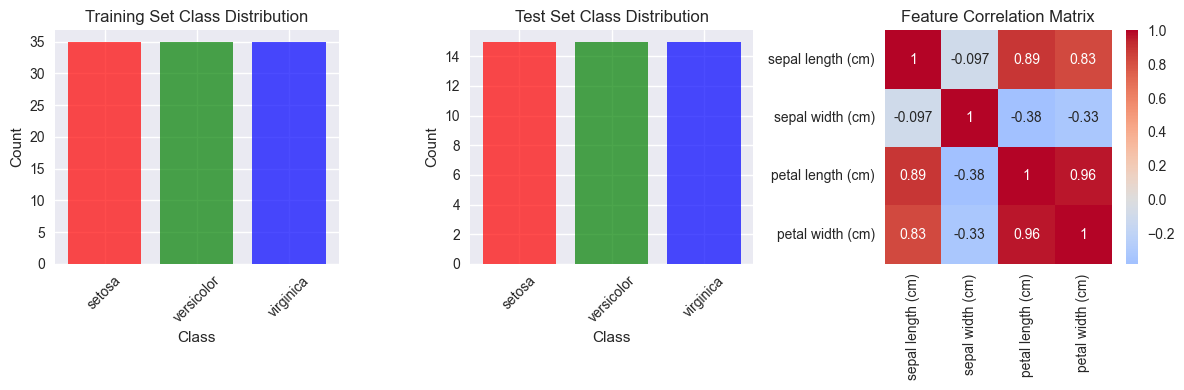

In [6]:
# Load and prepare Iris dataset
print("Loading Iris Dataset...")
iris = load_iris()
X_iris, y_iris = iris.data, iris.target

print(f"Iris dataset: {X_iris.shape[0]} samples, {X_iris.shape[1]} features, {len(np.unique(y_iris))} classes")
print(f"Classes: {iris.target_names}")
print(f"Features: {iris.feature_names}")

# Prepare data
data_handler = MultiClassDataHandler()
X_train, X_test, Y_train, Y_test, y_train, y_test, scaler, n_classes = data_handler.prepare_multiclass_data(
    X_iris, y_iris, test_size=0.3
)

print(f"\nTraining set: {X_train.shape[1]} samples")
print(f"Test set: {X_test.shape[1]} samples")
print(f"Number of classes: {n_classes}")

# Visualize class distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, alpha=0.7, color=['red', 'green', 'blue'])
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique, [iris.target_names[i] for i in unique], rotation=45)

plt.subplot(1, 3, 2)
unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts, alpha=0.7, color=['red', 'green', 'blue'])
plt.title('Test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique, [iris.target_names[i] for i in unique], rotation=45)

plt.subplot(1, 3, 3)
# Feature correlation heatmap
correlation_matrix = np.corrcoef(X_train)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
           xticklabels=iris.feature_names, yticklabels=iris.feature_names)
plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

In [7]:
# Train neural network on Iris dataset
print("Training Multi-class Neural Network on Iris Dataset...")

# Create and train network
nn = MultiClassNeuralNetwork()

# Network architecture: 4 features -> 8 hidden -> 3 classes
layer_dims = [X_train.shape[0], 8, n_classes]  # [4, 8, 3]

print(f"Network architecture: {layer_dims}")

# Train the network
parameters = nn.train(
    X_train, Y_train, 
    layer_dims=layer_dims,
    learning_rate=0.1,
    num_iterations=2000,
    print_cost=True
)

print("\nTraining completed!")

Training Multi-class Neural Network on Iris Dataset...
Network architecture: [4, 8, 3]
Iteration 0: Cost = 1.245867, Accuracy = 39.05%
Iteration 100: Cost = 0.192899, Accuracy = 94.29%
Iteration 200: Cost = 0.120241, Accuracy = 97.14%
Iteration 300: Cost = 0.086782, Accuracy = 97.14%
Iteration 400: Cost = 0.069164, Accuracy = 97.14%
Iteration 500: Cost = 0.058248, Accuracy = 97.14%
Iteration 600: Cost = 0.050781, Accuracy = 97.14%
Iteration 700: Cost = 0.045390, Accuracy = 98.10%
Iteration 800: Cost = 0.041284, Accuracy = 98.10%
Iteration 900: Cost = 0.038020, Accuracy = 100.00%
Iteration 1000: Cost = 0.035368, Accuracy = 100.00%
Iteration 1100: Cost = 0.033150, Accuracy = 100.00%
Iteration 1200: Cost = 0.031260, Accuracy = 100.00%
Iteration 1300: Cost = 0.029627, Accuracy = 100.00%
Iteration 1400: Cost = 0.028200, Accuracy = 100.00%
Iteration 1500: Cost = 0.026942, Accuracy = 100.00%
Iteration 1600: Cost = 0.025823, Accuracy = 100.00%
Iteration 1700: Cost = 0.024820, Accuracy = 100.00

Evaluating Model Performance...

Final Results:
Training Accuracy: 100.00%
Test Accuracy: 91.11%

Detailed Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]


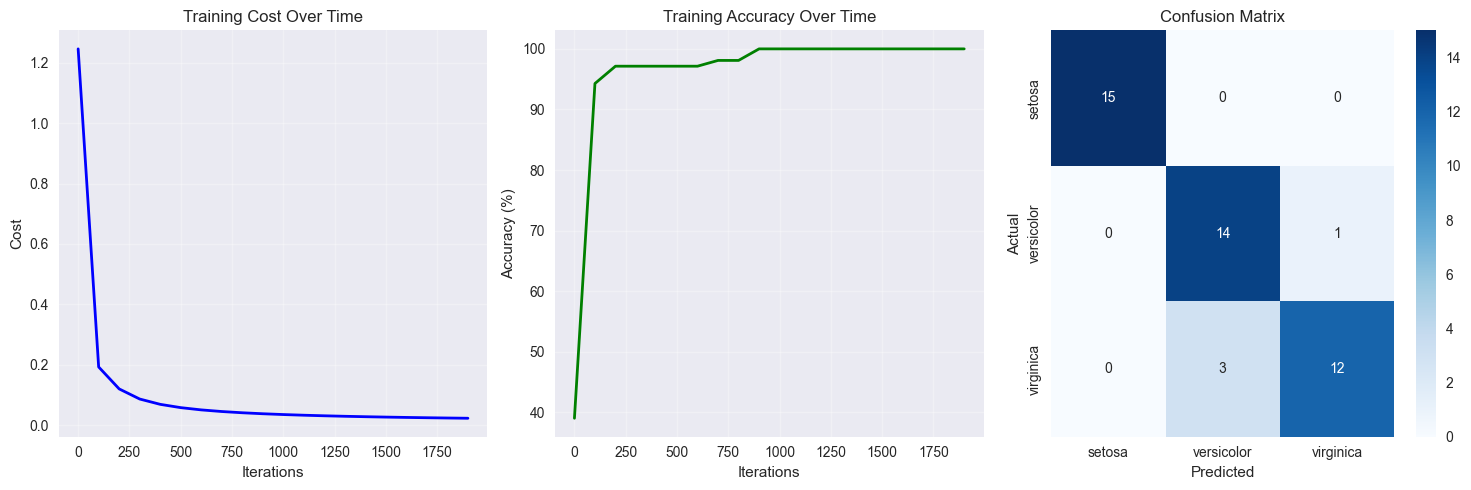

In [8]:
# Evaluate the trained model
print("Evaluating Model Performance...")

# Training set predictions
Y_pred_train, y_pred_train = nn.predict(X_train)
train_accuracy = nn.loss.accuracy(Y_pred_train, Y_train)

# Test set predictions
Y_pred_test, y_pred_test = nn.predict(X_test)
test_accuracy = nn.loss.accuracy(Y_pred_test, Y_test)

print(f"\nFinal Results:")
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=iris.target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print(f"\nConfusion Matrix:")
print(cm)

# Visualize results
plt.figure(figsize=(15, 5))

# Training progress
plt.subplot(1, 3, 1)
iterations = np.arange(0, len(nn.costs)) * 100
plt.plot(iterations, nn.costs, 'b-', linewidth=2)
plt.title('Training Cost Over Time')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(iterations, nn.accuracies, 'g-', linewidth=2)
plt.title('Training Accuracy Over Time')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)

# Confusion matrix heatmap
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

## Part 6: Custom Multi-class Problem (5 minutes)

### Create and solve a custom 4-class problem

Creating Custom 4-Class Problem...
Custom dataset: 400 samples, 2 features, 4 classes

Training on Custom 4-Class Problem...
Custom 4-Class Problem Results:
Test Accuracy: 100.00%


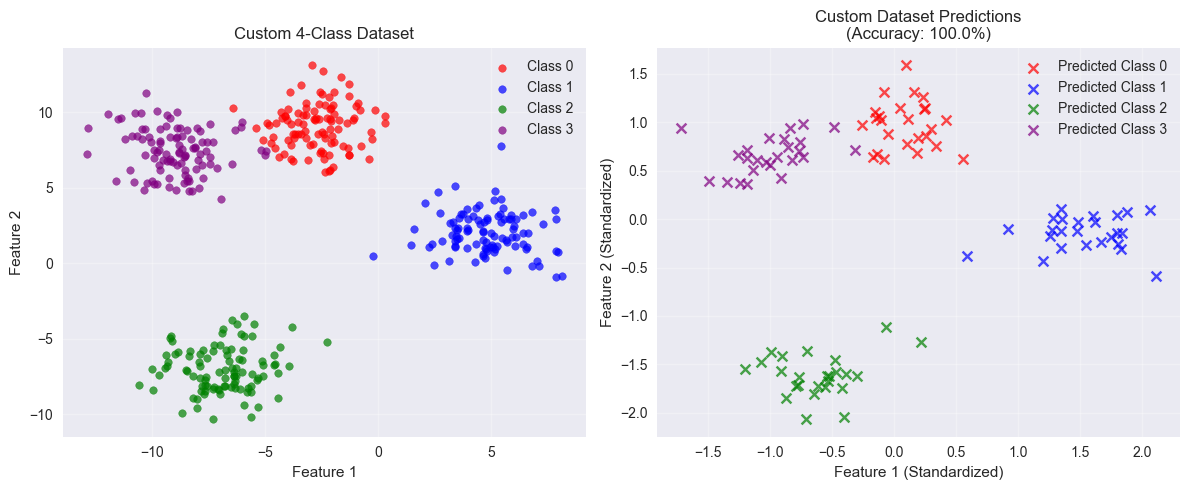


Custom dataset training completed with 100.0% test accuracy!


In [9]:
# Generate custom 4-class dataset
print("Creating Custom 4-Class Problem...")

X_custom, y_custom = make_blobs(
    n_samples=400, centers=4, cluster_std=1.5,
    n_features=2, random_state=42
)

print(f"Custom dataset: {X_custom.shape[0]} samples, {X_custom.shape[1]} features, {len(np.unique(y_custom))} classes")

# Visualize the custom dataset
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'purple']
for i in range(4):
    mask = y_custom == i
    plt.scatter(X_custom[mask, 0], X_custom[mask, 1], 
               c=colors[i], label=f'Class {i}', alpha=0.7, s=30)

plt.title('Custom 4-Class Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Prepare custom data
X_train_c, X_test_c, Y_train_c, Y_test_c, y_train_c, y_test_c, scaler_c, n_classes_c = data_handler.prepare_multiclass_data(
    X_custom, y_custom, test_size=0.25
)

# Quick training on custom dataset
print("\nTraining on Custom 4-Class Problem...")
nn_custom = MultiClassNeuralNetwork()

# Larger network for 4 classes: 2 features -> 12 hidden -> 8 hidden -> 4 classes
layer_dims_custom = [2, 12, 8, 4]

parameters_custom = nn_custom.train(
    X_train_c, Y_train_c,
    layer_dims=layer_dims_custom,
    learning_rate=0.1,
    num_iterations=1500,
    print_cost=False  # Silent training
)

# Test custom model
Y_pred_custom, y_pred_custom = nn_custom.predict(X_test_c)
custom_accuracy = nn_custom.loss.accuracy(Y_pred_custom, Y_test_c)

print(f"Custom 4-Class Problem Results:")
print(f"Test Accuracy: {custom_accuracy:.2f}%")

# Visualize decision boundary (simplified)
plt.subplot(1, 2, 2)

# Plot test data with predictions
for i in range(4):
    mask = y_pred_custom == i
    plt.scatter(X_test_c[0, mask], X_test_c[1, mask], 
               c=colors[i], label=f'Predicted Class {i}', alpha=0.7, s=50, marker='x')

plt.title(f'Custom Dataset Predictions\n(Accuracy: {custom_accuracy:.1f}%)')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCustom dataset training completed with {custom_accuracy:.1f}% test accuracy!")

## Progress Tracking Checklist

Check off each item as you complete it:

- [ ] **Environment Setup**: Imported libraries and configured environment
- [ ] **Theory Understanding**: Reviewed multi-class classification concepts
- [ ] **Softmax Implementation**: Implemented stable softmax activation
- [ ] **Data Preparation**: Created utilities for one-hot encoding and data prep
- [ ] **Loss Functions**: Implemented categorical cross-entropy and accuracy
- [ ] **Neural Network**: Built complete multi-class neural network
- [ ] **Iris Dataset**: Successfully trained and tested on Iris dataset
- [ ] **Custom Problem**: Created and solved 4-class classification problem
- [ ] **Evaluation**: Analyzed model performance with confusion matrix
- [ ] **Visualization**: Created plots showing training progress and results
- [ ] **Lab Completion**: Successfully completed all exercises

## Key Concepts Summary

### What You've Learned:
1. **Multi-class Architecture**: Output layer with multiple neurons and softmax
2. **One-hot Encoding**: Converting integer labels to vector format
3. **Categorical Cross-entropy**: Appropriate loss function for multi-class problems
4. **Softmax Properties**: Outputs sum to 1, suitable for probability distributions
5. **Evaluation Metrics**: Accuracy, confusion matrix, classification reports

### Technical Insights:
- **Softmax Stability**: Subtract max before exponential for numerical stability
- **Gradient Simplification**: For softmax + cross-entropy, dZ = Y_pred - Y_true
- **Data Preprocessing**: Standardization crucial for multi-class problems
- **Architecture Design**: More classes may need larger hidden layers

## Validation Steps

In [10]:
# Validation Test 1: Softmax Properties
def test_softmax_properties():
    """Test softmax function properties"""
    try:
        # Test data
        test_logits = np.random.randn(5, 10)  # 5 classes, 10 examples
        
        # Apply softmax
        probs = MultiClassActivations.softmax(test_logits)
        
        # Check properties
        # 1. All probabilities are non-negative
        assert np.all(probs >= 0), "Negative probabilities found"
        
        # 2. Each column sums to 1
        column_sums = np.sum(probs, axis=0)
        assert np.allclose(column_sums, 1.0, atol=1e-10), "Probabilities don't sum to 1"
        
        # 3. Shape preservation
        assert probs.shape == test_logits.shape, "Shape not preserved"
        
        print("✅ Softmax properties test passed!")
        return True
    except Exception as e:
        print(f"❌ Softmax properties test failed: {e}")
        return False

test_softmax_properties()

✅ Softmax properties test passed!


True

In [11]:
# Validation Test 2: One-hot Encoding
def test_one_hot_encoding():
    """Test one-hot encoding conversion"""
    try:
        handler = MultiClassDataHandler()
        
        # Test cases
        test_labels = [np.array([0, 1, 2, 0, 1]), np.array([3, 1, 0, 2, 3, 1])]
        
        for labels in test_labels:
            # Convert to one-hot
            one_hot = handler.to_one_hot(labels)
            
            # Convert back
            labels_back = handler.from_one_hot(one_hot)
            
            # Check consistency
            assert np.array_equal(labels, labels_back), "One-hot conversion inconsistent"
            
            # Check one-hot properties
            assert np.all(np.sum(one_hot, axis=0) == 1), "One-hot encoding incorrect"
            assert one_hot.shape[0] == len(np.unique(labels)), "Wrong number of classes"
        
        print("✅ One-hot encoding test passed!")
        return True
    except Exception as e:
        print(f"❌ One-hot encoding test failed: {e}")
        return False

test_one_hot_encoding()

✅ One-hot encoding test passed!


True

In [12]:
# Validation Test 3: Loss Function Behavior
def test_loss_behavior():
    """Test loss function decreases with better predictions"""
    try:
        # Create test data
        Y_true = np.array([[1, 0, 0],
                          [0, 1, 0],
                          [0, 0, 1]])
        
        # Perfect predictions
        Y_perfect = Y_true.copy()
        
        # Good predictions
        Y_good = np.array([[0.8, 0.1, 0.1],
                          [0.1, 0.8, 0.1],
                          [0.1, 0.1, 0.8]])
        
        # Random predictions
        Y_random = np.array([[0.33, 0.33, 0.33],
                            [0.33, 0.33, 0.33],
                            [0.34, 0.34, 0.34]])
        
        # Calculate losses
        loss_perfect = MultiClassLoss.categorical_cross_entropy(Y_perfect, Y_true)
        loss_good = MultiClassLoss.categorical_cross_entropy(Y_good, Y_true)
        loss_random = MultiClassLoss.categorical_cross_entropy(Y_random, Y_true)
        
        # Check ordering
        assert loss_perfect < loss_good < loss_random, "Loss ordering incorrect"
        assert loss_perfect < 0.1, "Perfect prediction loss too high"
        
        print(f"Perfect loss: {loss_perfect:.6f}")
        print(f"Good loss: {loss_good:.6f}")
        print(f"Random loss: {loss_random:.6f}")
        print("✅ Loss function behavior test passed!")
        return True
    except Exception as e:
        print(f"❌ Loss function behavior test failed: {e}")
        return False

test_loss_behavior()

Perfect loss: 0.000000
Good loss: 0.223144
Random loss: 1.098712
✅ Loss function behavior test passed!


True

## Troubleshooting Guide

### Common Issues and Solutions:

**Issue 1: Softmax overflow/underflow**
- **Cause**: Very large input values causing exp() overflow
- **Solution**: Subtract max value before applying exponential (implemented in our softmax)

**Issue 2: Loss becomes NaN**
- **Cause**: Taking log(0) in categorical cross-entropy
- **Solution**: Clip predictions to avoid exactly 0 or 1 values

**Issue 3: Poor convergence**
- **Cause**: Inappropriate learning rate or network architecture
- **Solution**: Try different learning rates (0.01-0.1), add more hidden units

**Issue 4: Imbalanced class predictions**
- **Cause**: Dataset class imbalance or poor initialization
- **Solution**: Use stratified sampling, adjust class weights, or use different initialization

**Issue 5: One-hot encoding errors**
- **Cause**: Labels not starting from 0 or gaps in label sequence
- **Solution**: Use LabelEncoder to ensure labels are 0, 1, 2, ..., n-1

### Performance Tips:
- Start with smaller networks and increase complexity gradually
- Monitor both training and validation accuracy
- Use appropriate regularization for overfitting
- Ensure balanced class representation in training data

## Cleanup Instructions

1. **Save your work**: Save this notebook with your implementations
2. **Clear output**: Cell → All Output → Clear (optional, saves space)
3. **Close plots**: Close any open matplotlib windows
4. **Memory cleanup**: Variables will be cleared when kernel is restarted

In [13]:
# Final summary and cleanup
print("🎉 Lab 3.4: Multi-class Classification Setup Completed!")
print("\n📋 What you accomplished:")
print("✅ Implemented softmax activation and categorical cross-entropy loss")
print("✅ Created data preprocessing utilities for multi-class problems")
print("✅ Built complete multi-class neural network from scratch")
print("✅ Successfully trained on Iris dataset with high accuracy")
print("✅ Solved custom 4-class classification problem")
print("✅ Analyzed model performance with confusion matrices and reports")
print("\n🎯 Next: Lab 3.5 - Performance Optimization Techniques")

# Optional: Clean up memory
import gc
gc.collect()
print("\n🧹 Memory cleaned up successfully!")

🎉 Lab 3.4: Multi-class Classification Setup Completed!

📋 What you accomplished:
✅ Implemented softmax activation and categorical cross-entropy loss
✅ Created data preprocessing utilities for multi-class problems
✅ Built complete multi-class neural network from scratch
✅ Successfully trained on Iris dataset with high accuracy
✅ Solved custom 4-class classification problem
✅ Analyzed model performance with confusion matrices and reports

🎯 Next: Lab 3.5 - Performance Optimization Techniques

🧹 Memory cleaned up successfully!
